In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
# import nct
import bct

#warnings.filterwarnings('ignore')

In [3]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [4]:
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [5]:
# this_seed2=700
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [6]:
#Select Largest Components
def select_largest_component_new(wires_dict):
    """
    Find and select largest connected component of the original graph G.
    Throws away unconnected components and updates all the keys in wires_dict 
    """
#     def connected_component_subgraphs(G):
#         for c in nx.connected_components(G):
#             yield G.subgraph(c)
    
    wires_dict['G'] = max(connected_component_subgraphs(wires_dict['G']), key=len)
#     set_trace()
    nw = len(wires_dict['G'].nodes())
    nj = len(wires_dict['G'].edges())   
    
    logging.info("The largest component has %5d nodes and %6d edges", nw, nj)

    # Replace values in the dictionary
    wires_dict['number_of_wires']     = nw
    wires_dict['number_of_junctions'] = nj
    wires_dict['xa'] = wires_dict['xa'][wires_dict['G'].nodes()] 
    wires_dict['ya'] = wires_dict['ya'][wires_dict['G'].nodes()] 
    wires_dict['xb'] = wires_dict['xb'][wires_dict['G'].nodes()] 
    wires_dict['yb'] = wires_dict['yb'][wires_dict['G'].nodes()]
    wires_dict['xc'] = wires_dict['xc'][wires_dict['G'].nodes()] 
    wires_dict['yc'] = wires_dict['yc'][wires_dict['G'].nodes()]
 
    # Keep old edge_list
    old_edge_list = [(ii, kk) for ii, kk in  zip(wires_dict['edge_list'][:, 0], wires_dict['edge_list'][:, 1])]
    # Remove old edge list
    wires_dict = wires.remove_key(wires_dict, 'edge_list') 
    # Save indices of intersections in the old graph
    ind_dict = {key:value for value,key in enumerate(old_edge_list)}
    new_edge_list = sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0])
    # Find intersection between the two sets
    inter = set(ind_dict).intersection(new_edge_list)
    # Retrieve edge indices/positions from the old list
    edges_idx = [ind_dict[idx] for idx in inter]
       
    # These have length equal to number of junctions -- only get the ones we need
    wires_dict['xi'] = wires_dict['xi'][edges_idx] 
    wires_dict['yi'] = wires_dict['yi'][edges_idx] 
    
    # Get contiguous numbering of nodes
    # Build node mapping 
    node_mapping    = {key:value for value, key in enumerate(sorted(wires_dict['G'].nodes()))}
    # This  step also renames edges list
    wires_dict['G'] =  nx.relabel_nodes(wires_dict['G'] , node_mapping)

    # Swap node vertices if vertex 0 is larger than vertex 1, then sort by first element
    wires_dict['edge_list'] = np.asarray(sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0]))
    
    # Save adjacency matrix of new graph
    wires_dict = wires.remove_key(wires_dict, 'adj_matrix') 
    wires_dict = wires.generate_adj_matrix(wires_dict)

    wire_distances = wires.cdist(np.array([wires_dict['xc'], wires_dict['yc']]).T, np.array([wires_dict['xc'], wires_dict['yc']]).T, metric='euclidean')    
    wires_dict['wire_distances'] = wire_distances

    return wires_dict 

In [7]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

## Generate 300nw ASN + C. Elegans:

In [8]:
# cElegans=loadmat("../CODE/Data/Organic Networks Connectomes/celegans277neurons.mat")

#     #C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Data\Organic Networks Connectomes\

In [9]:
# #set up dictionary for celegans:
# Elegans={'adj_matrix':[],'G':[],'Accuracy':{'Linear Transformation':[],'Memory Capacity':[]},'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}}

In [10]:
# elegansMat=cElegans['celegans277matrix']
# elegansGraph = nx.from_numpy_array(elegansMat)
# Elegans['adj_matrix']=elegansMat
# Elegans['G']=elegansGraph

In [11]:
# cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/"

In [12]:
# # if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
# print('Creating Parameters')
# #Set Paramaters for network generation: Centroid Dispersion, Wire Dispersion + Length of Wires
# params={'Centroid':150,'Wire Dispersion':[1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 80.0, 100.0, 150.0],'Length':100}
# numNetworks=1+len(params['Wire Dispersion'])+1 
# NWN=[None]*100

#     #loop through these:
# centroid2=params['Centroid']
# length2=params['Length']
# disp2=params['Wire Dispersion']
# for i in range(49):
#     temp=params['Centroid']
#     temp2=params['Length']
#     temp3=params['Wire Dispersion']
# #     length2=np.concatenate((length2,temp2))
#     disp2=np.concatenate((disp2,temp3))
# print('Parameters Saved')
# # else:
# # print('Parameters Loaded')

### Generate Modular vs Integrated Networks:

In [8]:
numNWs=300
numNetworks=10
numModules=2
density=6 #number of different density networks
seeds=[321,220,313,26,429,58,1,963,1002]
nw=[[[] for i in range(density)] for j in range(numNetworks)]
seeds2=[[] for i in range(numNetworks)]
for i in range(numNetworks):
    for j in range(len(seeds)):
        seeds2[i].append(np.random.randint(0,1000))
for network in tqdm(range(numNetworks)):   
    for j in range(density):
        for i in range(numModules):
            temp=wires.generate_wires_distribution(np.int(numNWs/numModules),this_seed=seeds[i]*seeds2[network][i],centroid_dispersion=700,wire_av_length=900,Lx=2000.0,Ly=2000.0)
            temp=wires.detect_junctions(temp)
            temp=wires.generate_adj_matrix(temp)
            temp=wires.generate_graph(temp)
            temp=select_largest_component_new(temp)
            nw[network][j].append(temp)
oldnw=nw

  0%|          | 0/10 [00:00<?, ?it/s]2021-06-18 15:03:20,505:INFO:Detecting junctions
2021-06-18 15:03:20,597:INFO:Finished detecting junctions
2021-06-18 15:03:20,604:INFO:The largest component has    75 nodes and    501 edges
2021-06-18 15:03:20,615:INFO:Detecting junctions
2021-06-18 15:03:20,708:INFO:Finished detecting junctions
2021-06-18 15:03:20,715:INFO:The largest component has    75 nodes and    510 edges
2021-06-18 15:03:20,725:INFO:Detecting junctions
2021-06-18 15:03:20,817:INFO:Finished detecting junctions
2021-06-18 15:03:20,824:INFO:The largest component has    75 nodes and    528 edges
2021-06-18 15:03:20,835:INFO:Detecting junctions
2021-06-18 15:03:20,929:INFO:Finished detecting junctions
2021-06-18 15:03:20,936:INFO:The largest component has    75 nodes and    518 edges
 10%|█         | 1/10 [00:00<00:03,  2.26it/s]2021-06-18 15:03:20,948:INFO:Detecting junctions
2021-06-18 15:03:21,041:INFO:Finished detecting junctions
2021-06-18 15:03:21,048:INFO:The largest comp

In [40]:
# compressed_pickle(nw,'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_4_modules_separated_10sets_NWN.pkl')

In [18]:
nw=[]
nw=oldnw

In [51]:
if numModules==4:
    dist=np.linspace(0,1950,density)
elif numModules==9:
    dist=np.linspace(0,1400,density)
elif numModules==2:
#     dist=np.linspace(0,1750,density)
    dist=np.linspace(0,2550,density)

# nw=[]
# nw=oldnw #if distance doesn't work, uncomment and run this

if numModules==9:
    for network in tqdm(range(numNetworks)):
        for i in range(numModules):
            for j in range(len(dist)):
                if i == 1:
                    nw[network][j][i]['ya']+=dist[j]
                    nw[network][j][i]['yb']+=dist[j]
                    nw[network][j][i]['yc']+=dist[j]
                elif i==2:
                    nw[network][j][i]['ya']+=dist[j]
                    nw[network][j][i]['yb']+=dist[j]
                    nw[network][j][i]['yc']+=dist[j]
                    nw[network][j][i]['xc']+=dist[j]
                    nw[network][j][i]['xa']+=dist[j]
                    nw[network][j][i]['xb']+=dist[j]
                elif i==3:
                    nw[network][j][i]['xc']+=dist[j]
                    nw[network][j][i]['xa']+=dist[j]
                    nw[network][j][i]['xb']+=dist[j]
                elif i ==4:
                    nw[network][j][i]['yc']+=dist[j]*2
                    nw[network][j][i]['ya']+=dist[j]*2
                    nw[network][j][i]['yb']+=dist[j]*2
                elif i == 5:
                    nw[network][j][i]['xc']+=dist[j]*2
                    nw[network][j][i]['xa']+=dist[j]*2
                    nw[network][j][i]['xb']+=dist[j]*2
                    nw[network][j][i]['yc']+=dist[j]*2
                    nw[network][j][i]['ya']+=dist[j]*2
                    nw[network][j][i]['yb']+=dist[j]*2
                elif i == 6:
                    nw[network][j][i]['xc']+=dist[j]*2
                    nw[network][j][i]['xa']+=dist[j]*2
                    nw[network][j][i]['xb']+=dist[j]*2
                elif i == 7:
                    nw[network][j][i]['xc']+=dist[j]*2
                    nw[network][j][i]['xa']+=dist[j]*2
                    nw[network][j][i]['xb']+=dist[j]*2
                    nw[network][j][i]['ya']+=dist[j]
                    nw[network][j][i]['yb']+=dist[j]
                    nw[network][j][i]['yc']+=dist[j]
                elif i == 8:
                    nw[network][j][i]['ya']+=dist[j]*2
                    nw[network][j][i]['yb']+=dist[j]*2
                    nw[network][j][i]['yc']+=dist[j]*2
                    nw[network][j][i]['xc']+=dist[j]
                    nw[network][j][i]['xa']+=dist[j]
                    nw[network][j][i]['xb']+=dist[j]
elif numModules==2:
    for network in tqdm(range(numNetworks)):
        for i in range(numModules):
            for j in range(len(dist)):
                if i == 1:
                    nw[network][j][i]['xc']+=dist[j]
                    nw[network][j][i]['xa']+=dist[j]
                    nw[network][j][i]['xb']+=dist[j]
                    
elif numModules==4:
    for network in tqdm(range(numNetworks)):
        for i in range(numModules):
            for j in range(len(dist)):
                if i == 1:
                    nw[network][j][i]['ya']+=dist[j]
                    nw[network][j][i]['yb']+=dist[j]
                    nw[network][j][i]['yc']+=dist[j]
                elif i==2:
                    nw[network][j][i]['xa']+=dist[j]
                    nw[network][j][i]['xb']+=dist[j]
                    nw[network][j][i]['xc']+=dist[j]
                elif i==3:
                    nw[network][j][i]['ya']+=dist[j]
                    nw[network][j][i]['yb']+=dist[j]
                    nw[network][j][i]['yc']+=dist[j]
                    nw[network][j][i]['xc']+=dist[j]
                    nw[network][j][i]['xa']+=dist[j]
                    nw[network][j][i]['xb']+=dist[j]

In [52]:
def checkOutside(wires_dict):
    xa, xb, ya, yb = wires_dict['xa'], wires_dict['xb'], wires_dict['ya'], wires_dict['yb']
    Lx, Ly         = wires_dict['Lx'], wires_dict['Ly']
    a = np.where(np.vstack([xa, xb, ya, yb]) < 0.0, True, False).sum(axis=0)
    b = np.where(np.vstack([xa, xb]) > Lx, True, False).sum(axis=0)
    c = np.where(np.vstack([ya, yb]) > Ly, True, False).sum(axis=0)

    outside = a + b + c
    wires_dict['outside'] = outside
#     return outside

In [53]:
combined = [[dict() for i in range(density)] for j in range(numNetworks)]

In [54]:
for network in range(len(nw)):
    xa=[[] for i in range(density)];xb=[[] for i in range(density)];xc=[[] for i in range(density)]
    ya=[[] for i in range(density)];yb=[[] for i in range(density)];yc=[[] for i in range(density)]
    for i in range(len(nw[network])):
        for j in range(len(nw[network][i])):
            xa[i].append(nw[network][i][j]['xa'])
            xb[i].append(nw[network][i][j]['xb'])
            ya[i].append(nw[network][i][j]['ya'])
            yb[i].append(nw[network][i][j]['yb'])
            xc[i].append(nw[network][i][j]['xc'])
            yc[i].append(nw[network][i][j]['xc'])
        combined[network][i]['xa']=np.hstack(xa[i])
        combined[network][i]['xb']=np.hstack(xb[i])
        combined[network][i]['xc']=np.hstack(xc[i])
        combined[network][i]['ya']=np.hstack(ya[i])
        combined[network][i]['yb']=np.hstack(yb[i])
        combined[network][i]['yc']=np.hstack(yc[i])
        combined[network][i]['number_of_wires']=len(combined[network][i]['xa'])
        combined[network][i]['Lx']=dist[i]+nw[0][0][0]['length_x']
        combined[network][i]['Ly']=dist[i]+nw[0][0][0]['length_y']
        checkOutside(combined[network][i])

In [55]:
for i in tqdm(range(len(combined))):
    for j in range(len(combined[i])):
        wires.detect_junctions(combined[i][j])
        wires.generate_adj_matrix(combined[i][j])
        wires.generate_graph(combined[i][j])
        combined[i][j]=select_largest_component_new(combined[i][j])

2021-02-24 10:38:16,430:INFO:Detecting junctions
2021-02-24 10:38:17,874:INFO:Finished detecting junctions
2021-02-24 10:38:17,986:INFO:The largest component has   300 nodes and  12725 edges
2021-02-24 10:38:18,108:INFO:Detecting junctions
2021-02-24 10:38:19,518:INFO:Finished detecting junctions
2021-02-24 10:38:19,619:INFO:The largest component has   300 nodes and  11532 edges
2021-02-24 10:38:19,731:INFO:Detecting junctions
2021-02-24 10:38:21,095:INFO:Finished detecting junctions
2021-02-24 10:38:21,176:INFO:The largest component has   300 nodes and   9189 edges
2021-02-24 10:38:21,266:INFO:Detecting junctions
2021-02-24 10:38:22,588:INFO:Finished detecting junctions
2021-02-24 10:38:22,654:INFO:The largest component has   300 nodes and   7273 edges
2021-02-24 10:38:22,726:INFO:Detecting junctions
2021-02-24 10:38:24,015:INFO:Finished detecting junctions
2021-02-24 10:38:24,075:INFO:The largest component has   300 nodes and   6465 edges
2021-02-24 10:38:24,141:INFO:Detecting juncti

2021-02-24 10:39:22,705:INFO:Detecting junctions
2021-02-24 10:39:24,133:INFO:Finished detecting junctions
2021-02-24 10:39:24,238:INFO:The largest component has   300 nodes and  12055 edges
2021-02-24 10:39:24,354:INFO:Detecting junctions
2021-02-24 10:39:25,729:INFO:Finished detecting junctions
2021-02-24 10:39:25,814:INFO:The largest component has   300 nodes and   9744 edges
2021-02-24 10:39:25,909:INFO:Detecting junctions
2021-02-24 10:39:27,236:INFO:Finished detecting junctions
2021-02-24 10:39:27,306:INFO:The largest component has   300 nodes and   7513 edges
2021-02-24 10:39:27,381:INFO:Detecting junctions
2021-02-24 10:39:28,670:INFO:Finished detecting junctions
2021-02-24 10:39:28,729:INFO:The largest component has   300 nodes and   6504 edges
2021-02-24 10:39:28,795:INFO:Detecting junctions
2021-02-24 10:39:30,082:INFO:Finished detecting junctions
2021-02-24 10:39:30,139:INFO:The largest component has   300 nodes and   6362 edges
2021-02-24 10:39:30,206:INFO:Detecting juncti

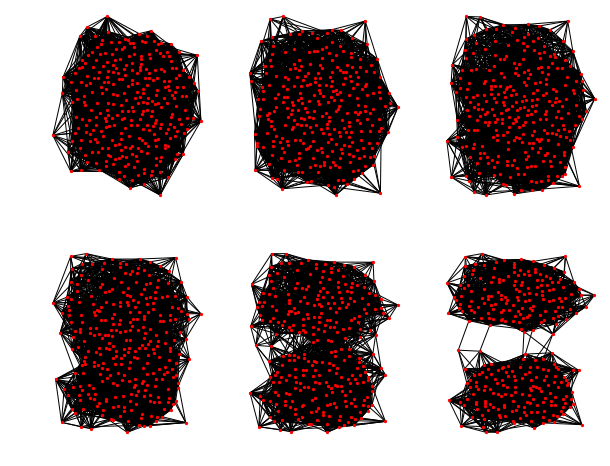

In [56]:
fig,axes=plt.subplots(2,3,figsize=(10,8))
network=1
i = 0
for ax in axes.flat:
    pos=nx.kamada_kawai_layout(combined[network][i]['G'])
    nx.draw(combined[network][i]['G'],pos=pos,ax=ax,node_size=5)
    i=i+1

In [61]:
np.mean([deg for val,deg in combined[0][-1]['G'].degree()])

42.18

In [62]:
compressed_pickle(combined,'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_avgDeg42_NWN.pkl')

In [118]:
combined=decompress_pickle('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_9_modules_10sets_NWN.pkl')

In [31]:
NWN=combined

In [120]:
NWN_sep=combined

### Load NWNs from wires.py

In [9]:
import glob
import os
path='/import/silo2/aloe8475/Documents/CODE/Analysis/Generate Networks/connectivity_data/'
networks=[]
files=glob.glob(path+'./*.mat')
files.sort(key=os.path.basename) #sort by creation time (name works weirdly)
for i in files:
    networks.append(loadmat(i))


In [10]:
np.mean([i for j,i in nx.from_numpy_array(networks[1]['adj_matrix']).degree])

11.575418994413408

In [11]:
compressed_pickle(networks,'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VaryingSize_SameDensity.pkl')

In [12]:
len(networks)

50

In [12]:
# temp=[]
# for i in range(20):
#     idx1=i*10
#     idx2=idx1+10
#     if i==0:
#         temp.append(NWN[i:10])
#     else:
#         temp.append(NWN[idx1:idx2])
# NWN=[] 
# NWN=temp

In [516]:
# temp=[]
# pcoeff=[]
# mz=[]
# mod=[]
# for i in range(len(NWN)):
#     temp.append(np.mean(np.array(nx.from_numpy_matrix(NWN[i]['adj_matrix']).degree())[:,1]))
#     ci,q=nct.community_louvain(NWN[i]['adj_matrix'])
#     pcoeff.append(bct.participation_coef(NWN[i]['adj_matrix'],ci))
#     mz.append(bct.module_degree_zscore(NWN[i]['adj_matrix'],ci))
#     mod.append(q)

# Graph Theory

In [11]:
# if (not os.path.isfile('networks_LinearTransformation.pkl')): #if we haven't saved the file
print('Setting up Graph Theory')
for i in range(len(NWN)):
        for j in range(len(NWN[i])):
            NWN[i][j].update({'Graph Theory':{'Small World':[],'Modularity':[],'CCoeff':[],'MZ':[],'PCoeff':[],'PL':[]}})
# else:
# print('Graph Theory Already Loaded')

Setting up Graph Theory


KeyError: 0

In [33]:
#export adj matrices to calculate small worldness in matlab:
adj_mats={"AdjMat":[]}
for i in range(len(NWN)):
        for j in range(len(NWN[i])):
            adj_mats['AdjMat'].append((NWN[i][j]['adj_matrix']))
savemat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300NW_9modules_10sets.mat',adj_mats)

# savemat('/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VaryingDensity300NWset2_NWN.mat',adj_mats)
#C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks\

In [53]:
# Small Worldness: 
# ------------------------------------
# CALCULATED IN MATLAB: smallworldness.m 
# found in C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks
# ------------------------------------
temp=loadmat(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/300NW_2modules_10sets_smallworld.mat')

# temp=loadmat(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/VaryingDensity300NWset2_NWN_smallworld.mat')
smallworld=temp['smallworld'][0]
del temp

In [64]:
smallworld=smallworld.reshape(10,6)

In [65]:
smallworld

array([[0.64788937, 0.6503784 , 0.65735291, 0.66114128, 0.66161717,
        0.63052794],
       [0.64959936, 0.65384382, 0.66469714, 0.67475261, 0.67325107,
        0.64854021],
       [0.6510433 , 0.64083164, 0.64504226, 0.65255073, 0.65801911,
        0.60083251],
       [0.64106432, 0.63362336, 0.63456944, 0.63960395, 0.6500829 ,
        0.64370523],
       [0.6537725 , 0.66093229, 0.65131172, 0.66582357, 0.67148252,
        0.65591206],
       [0.65741448, 0.66165008, 0.66782158, 0.67469282, 0.68136969,
        0.65702947],
       [0.6477061 , 0.63533225, 0.64855527, 0.66122758, 0.65675376,
        0.6404654 ],
       [0.647322  , 0.65489671, 0.65320306, 0.6553853 , 0.66225976,
        0.64045855],
       [0.64625027, 0.64848556, 0.65357978, 0.66288485, 0.66748223,
        0.65046471],
       [0.64856075, 0.64964221, 0.65370319, 0.66376599, 0.65753617,
        0.64435975]])

In [34]:
# Modularity, PCoeff, Small Worldness & MZ:
ci = []
pcoeff= []
mz= []
clustering = []
for i in tqdm(range(len(NWN))):
    for j in range(len(NWN[i])):
        #need to do louvain check with partition distance 16/10/2020
        ci,q=bct.community_louvain(NWN[i][j]['adj_matrix'])
        pcoeff=bct.participation_coef(NWN[i][j]['adj_matrix'],ci)
        mz=bct.module_degree_zscore(NWN[i][j]['adj_matrix'],ci)
        G=nx.from_numpy_matrix(NWN[i][j]['adj_matrix'])
        clustering=nx.clustering(G)
        NWN[i][j]['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(G))
        NWN[i][j]['Graph Theory']['Modularity']=ci
        NWN[i][j]['Graph Theory']['Modularity Score']=q
        NWN[i][j]['Graph Theory']['PCoeff']=pcoeff
        NWN[i][j]['Graph Theory']['MZ']=mz
#         NWN[i][j]['Graph Theory']['Small World']=smallworld[i][j]
        NWN[i][j]['Graph Theory']['CCoeff']=clustering
        NWN[i][j]['Graph Theory']['Degree']=nx.degree(G)
        NWN[i][j]['Graph Theory']['AvgPL']=nx.average_shortest_path_length(G)
#Save networks so we don't have to run this every time
# name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/VaryingDensity300NWset2_NWN.pkl'
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/300NW_9modules_10sets_NWN.pkl'

with open(name, 'wb') as f:
    pickle.dump([NWN], f)   

In [57]:
#More Graph Theory:
#Number of Junctions
junctions=[]
#Number of Nodes:
nodes=[]
avgPL=[]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        junctions.append(ASN300[i][j]['number_of_junctions'])
        nodes.append(ASN300[i][j]['number_of_wires'])

junctions=np.asarray(junctions)
nodes=np.asarray(nodes)

NameError: name 'ASN300' is not defined

In [8]:
cd "/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/"

/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity


In [ ]:
# #Export Degree to matlab for BIC analysis

# import scipy.stats as stats    
# degree=[None]*300
# pcoeff=[None]*300
# mz=[None]*300
# centrality=[None]*300
# #Gamma, Exponential, WB, Power Law Fitting:
# count=0
# for i in range(len(ASN300)):
#     for j in range(len(ASN300[i])):
#         degree[count]=(list(dict(ASN300[i][j]['Graph Theory']['Degree']).values()))  
#         pcoeff[count]=(list(ASN300[i][j]['Graph Theory']['PCoeff']))        
#         centrality[count]=(list(nx.betweenness_centrality(ASN300[i][j]['G']).values()))  
#         mz[count]=(list(ASN300[i][j]['Graph Theory']['MZ']))
#         count+=1
    
# savemat('Degree.mat',{'pcoeff':pcoeff,'degree':degree,'maxIdx':max_idx_acc,'minIdx':min_idx_acc,'centrality':centrality,'mz':mz})


## C. Elegans

In [ ]:
#Small world calculated on C Elegans Matrix in smallworld.m in MATLAB
temp=loadmat(r'cElegans_smallworld.mat')
smallworld_elegans=temp['cElegansSW'][0]
del temp

In [ ]:
# Modularity, PCoeff, Small Worldness & MZ:
if (not os.path.isfile('elegans_LinearTransformation.pkl')): #if we haven't saved the file
    ci = []
    pcoeff= []
    mz= []

    ci,q=nct.community_louvain(elegansMat)
    pcoeff=bct.participation_coef(elegansMat,ci)
    mz=bct.module_degree_zscore(elegansMat,ci)
    Elegans['Graph Theory']['MZ']=mz
    Elegans['Graph Theory']['PCoeff']=pcoeff
    Elegans['Graph Theory']['Modularity']=ci
    Elegans['Graph Theory']['Modularity Score']=q
    Elegans['Graph Theory']['Small World']=smallworld_elegans
    Elegans['Graph Theory']['PL']=dict(nx.all_pairs_shortest_path_length(elegansGraph))
    Elegans['Graph Theory']['CCoeff']=nx.clustering(elegansGraph)
    Elegans['Graph Theory']['Degree']=nx.degree(elegansGraph)

   #Save networks so we don't have to run this every time
    print('Saving Elegans Networks')
    name='elegans_LinearTransformation.pkl'
    with open(name, 'wb') as f:
        pickle.dump([Elegans], f)

else: #load pickle file + communicability matrix calculated in Linear Transformation section 
    name='elegans_LinearTransformation.pkl'
    print('Loading Elegans Networks')
    file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
    [Elegans] = pickle.load(file)

    print('Loaded')